In [1]:
import collections
import networkx as nx
import sys
import os
# dir_path = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
# sys.path.append(dir_path)
sys.path.append(r'c:\\Users\\rotim\\OneDrive\\Documents\\Reading\\graph-code\\Skoltech-PhD-Thesis\\_codes\\SIR\\Influential-nodes-identification-in-complex-networks-via-information-entropy')
from algorithms import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle

In [2]:
# data_file = 'topo' # 'HepPh'

# G = clean_data(data_file)
# print(nx.number_of_nodes(G), nx.number_of_edges(G))

graph_collections, graph_name = read_graph("./test-graphs")
G = graph_collections[0]
# print(graph_name)


{'ABILENE': {'index': 0, 'nodes': 11, 'edges': 14}, 'ABVT': {'index': 1, 'nodes': 23, 'edges': 31}, 'AGIS': {'index': 2, 'nodes': 25, 'edges': 30}, 'ARN.GRAPHML': {'index': 3, 'nodes': 30, 'edges': 29}, 'BELLCANADA': {'index': 4, 'nodes': 48, 'edges': 64}, 'BELLSOUTH.GRAPHML': {'index': 5, 'nodes': 51, 'edges': 66}, 'BICS.GRAPHML': {'index': 6, 'nodes': 33, 'edges': 48}, 'CERNET.GRAPHML': {'index': 7, 'nodes': 41, 'edges': 58}, 'CESNET200706.GRAPHML': {'index': 8, 'nodes': 44, 'edges': 51}, 'CHINANET.GRAPHML': {'index': 9, 'nodes': 42, 'edges': 66}, 'COGENTCO.GRAPHML': {'index': 10, 'nodes': 197, 'edges': 243}, 'COLT.GRAPHML': {'index': 11, 'nodes': 153, 'edges': 177}, 'DELTACOM.GRAPHML': {'index': 12, 'nodes': 113, 'edges': 161}, 'GARR201110.GRAPHML': {'index': 13, 'nodes': 59, 'edges': 74}, 'GEANT2001': {'index': 14, 'nodes': 27, 'edges': 38}, 'GRNET.GRAPHML': {'index': 15, 'nodes': 37, 'edges': 42}, 'INTELLIFIBER.GRAPHML': {'index': 16, 'nodes': 73, 'edges': 95}, 'INTEROUTE.GRAPHML'

Our Model

In [41]:
# geo_loc_data = get_geo_data("Internet2LatLong.csv")
geo_loc_data = {k: {"lat": v.get('Latitude', 0), "long": v.get('Longitude', 0)}
                for (k, v) in G.nodes(data=True)}
# print(geo_loc_data)
edge_geo_data_combined = assign_location(G, geo_loc_data)
# set edge attributes
set_edge_attr(G, edge_geo_data_combined)
# obtain the node degrees and edges weights to desired lengths
tmp_t = list(range(1, 5))
tmp_t_SN, tmp_t_hub = hubs_SN_NS(G, tmp_t)
G = graph_collections[0]
combined_dict, combined_dict_k_2 = varying_examples(tmp_t_SN[0][1], tmp_t_hub[1][2])

# Get ranked result
opti_rank, ranked_nodes = rank_result(combined_dict, combined_dict_k_2)
# print()
opti_rank


[('7', 0.999028599121206),
 ('8', 0.9931467209871861),
 ('6', 0.7571798128170234),
 ('9', 0.7562986118582249),
 ('5', 0.7016084028819796),
 ('4', 0.5915030963200972),
 ('10', 0.5603575276295959)]

In [42]:
geo_loc_data_all = {i: {k: {"lat": v.get('Latitude', 0), "long": v.get('Longitude', 0)}
     for (k, v) in g.nodes(data=True)} for i, g in zip(graph_name, graph_collections)}
geo_loc_data_all
edge_geo_data_combined_all = {k: assign_location(g, v) for (k, v), g in zip(geo_loc_data_all.items(), graph_collections)}
# print(edge_geo_data_combined_all)
[set_edge_attr(g, v[1]) for (v ,g) in zip(edge_geo_data_combined_all.items(), graph_collections)]

tmp_t = list(range(1, 3))
combi_ = {k: hubs_SN_NS(g, tmp_t) for g,k in zip(graph_collections, graph_name)}
# combi_["ABILENE"]
all_ranks = {k: [rank_result(*varying_examples(v_[0][1], v_[1][2])) for v_ in v]
 for k, v in combi_.items()}
# edge_geo_data_combined_all
# all_ranks


In [25]:
# summary_stat = {k: {"Graph": k,
#     "nodes": nx.number_of_nodes(f), 
#     "egdes": nx.number_of_edges(f), 
#     "density": nx.density(f), 
#     "diameter": nx.diameter(f),
#     "transitivity": nx.transitivity(f),
#     "average path length": nx.average_shortest_path_length(f),
#     "average degree": sum([d for (n, d) in nx.degree(f)]) / float(f.number_of_nodes()),
#     "average weighted degree": sum([q[1] for q in list(f.degree(weight='weight'))])/float(f.number_of_nodes()),
#     "optimal ranks": {*v[0][0]},
#     "node_cluster": cluster_optimal_nodes(f, v[0][0])
#                     } for f, k, (k2, v) in zip(graph_collections, graph_name, all_ranks.items()) if k2 == k}



In [7]:
# df = pd.DataFrame([v for v in summary_stat.values()])
# df.to_csv(r'raw_ranking.csv', index=False, header=True)

In [43]:
max_ = len(opti_rank)/nx.number_of_nodes(G)  # 0.16
max_topk = round(max_ * nx.number_of_nodes(G))
print(max_topk)


7


In [3]:
nx.eccentricity(G)

{'0': 5,
 '1': 4,
 '2': 5,
 '3': 5,
 '4': 5,
 '5': 4,
 '6': 4,
 '7': 3,
 '8': 3,
 '9': 4,
 '10': 3}

In [18]:
def maxi_mini(a=[], b=[], c=[], d=[],  epsilon=0.15, mu=0.15, no_of_evidences = 2):
    def maxi_(l):
        return max([j for i, j in l])
    def mini_(k):
        return min([j for i, j in k])
    sigma = maxi_(a)-mini_(a) + (2*mu)
    delta = maxi_(b)-mini_(b) + (2*epsilon)
    if (no_of_evidences == 2):
        return maxi_(a), mini_(a), maxi_(b), mini_(b), sigma, delta
    elif (no_of_evidences == 3):
        return maxi_(a), mini_(a), maxi_(b), mini_(b), maxi_(c), mini_(c), sigma, delta
    elif (no_of_evidences == 4):
        return maxi_(a), mini_(a), maxi_(b), mini_(b), maxi_(c), mini_(c),  maxi_(d), mini_(d), sigma, delta

    # k_max, k_min, k_2_max, k_2_min, k_3_max, k_3_min, k_4_max, k_4_min = max([j for i, j in a]), min([j for i, j in a]), 
    # max([j for i, j in b]), min([j for i, j in b]), 
    # max([j for i, j in c]), min([j for i, j in c]), 
    # max([j for i, j in d]), min([j for i, j in d])  # two_SN
    # sigma = k_max-k_min+(2*mu)
    # delta = k_2_max-k_2_min+(2*epsilon)
    # if a and b:
    #     return k_max, k_min, k_2_max, k_2_min, sigma, delta
    # elif  not c:
    #     return k_max, k_min, k_2_max, k_2_min,  k_3_max, k_3_min, sigma, delta
    # elif not d:
    #     return k_max, k_min, k_2_max, k_2_min,  k_3_max, k_3_min, k_4_max, k_4_min, sigma, delta


def probability_weights(d, two_SN, k_max, k_min, k_2_max, k_2_min, sigma, delta):
    w_d_h, w_d_2_h = [(i, abs(k-k_min)/sigma) for (i, k)
                      in d], [(i, abs(k-k_2_min)/delta) for (i, k) in two_SN]
    w_d_l, w_d_2_l = [(i, abs(k-k_max)/sigma) for (i, k)
                      in d], [(i, abs(k-k_2_max)/delta) for (i, k) in two_SN]
    w_d_t, w_d_2_t = [(i, 1-(abs(k-k_min)/sigma + abs(k-k_max)/sigma))
                      for i, k in d], [(i, 1-(abs(k-k_2_min)/delta + abs(k-k_2_max)/delta))
                                       for i, k in two_SN]

    return w_d_h, w_d_2_h, w_d_l, w_d_2_l, w_d_t, w_d_2_t

# def probability_weights(d, two_SN, k_max, k_min, k_2_max, k_2_min, sigma, delta):
#     w_d_h, w_d_2_h = [(i, abs(k-k_min)/sigma) for (i, k)
#                       in d], [(i, abs(k-k_2_min)/delta) for (i, k) in two_SN]
#     w_d_l, w_d_2_l = [(i, abs(k-k_max)/sigma) for (i, k)
#                       in d], [(i, abs(k-k_2_max)/delta) for (i, k) in two_SN]
#     w_d_t, w_d_2_t = [(i, 1-(abs(k-k_min)/sigma + abs(k-k_max)/sigma))
#                       for i, k in d], [(i, 1-(abs(k-k_2_min)/delta + abs(k-k_2_max)/delta))
#                                        for i, k in two_SN]

#     return w_d_h, w_d_2_h, w_d_l, w_d_2_l, w_d_t, w_d_2_t


def probability_weights_multi(*maxi_mini_results, e_1=[], e_2=[], e_3=[], e_4=[], number_of_evidences = 2):
    def pby_weights(a,b,c):
        return [(i, abs(k-a)/b) for (i, k) in c]
    w_d_h, w_d_2_h = pby_weights(maxi_mini_results[1], maxi_mini_results[4], e_1),pby_weights(maxi_mini_results[3],maxi_mini_results[5],e_2)
    w_d_l, w_d_2_l = pby_weights(maxi_mini_results[0], maxi_mini_results[4],e_1),pby_weights(maxi_mini_results[2],maxi_mini_results[5],e_2)
    w_d_t, w_d_2_t = [(i[0], 1-(i[1]+j[1])) for i,j in zip(w_d_h, w_d_l)], [(i[0], 1-(i[1]+j[1])) for i,j in zip(w_d_2_h, w_d_2_l)]

    return w_d_h, w_d_2_h, w_d_l, w_d_2_l, w_d_t, w_d_2_t




In [19]:
print(maxi_mini(a=[(3, 4), (4, 7)], b=[(6, 2), (3, 2)]))
two_sources = maxi_mini(a=[(3, 4), (4, 7)], b=[(6, 2), (3, 2)])
print("Two sources of evidence:", two_sources)
print(maxi_mini(a=[(3, 4), (4, 7)], b=[(6, 2), (3, 2)], c=[(6, 8), (3, 10)], no_of_evidences=3))
print()
print("max_multi:", maxi_mini(a=[(3, 4), (4, 7)], b=[(6, 2), (3, 2)], c=[(6, 8), (3, 10)], d =[(6, 8), (3, 10)], no_of_evidences=4))
print()
print(probability_weights_multi(*two_sources, e_1=[(3, 4), (4, 7)], e_2=[(6, 2), (3, 2)]))
print()
probability_weights([(3, 4), (4, 7)], [(6, 2), (3, 2)], *two_sources)


(7, 4, 2, 2, 3.3, 0.3)
Two sources of evidence: (7, 4, 2, 2, 3.3, 0.3)
(7, 4, 2, 2, 10, 8, 3.3, 0.3)

max_multi: (7, 4, 2, 2, 10, 8, 10, 8, 3.3, 0.3)

([(3, 0.0), (4, 0.9090909090909092)], [(6, 0.0), (3, 0.0)], [(3, 0.9090909090909092), (4, 0.0)], [(6, 0.0), (3, 0.0)], [(3, 0.09090909090909083), (4, 0.09090909090909083)], [(6, 1.0), (3, 1.0)])



([(3, 0.0), (4, 0.9090909090909092)],
 [(6, 0.0), (3, 0.0)],
 [(3, 0.9090909090909092), (4, 0.0)],
 [(6, 0.0), (3, 0.0)],
 [(3, 0.09090909090909083), (4, 0.09090909090909083)],
 [(6, 1.0), (3, 1.0)])

In [7]:
def my_function(**kid):
  print(kid["nname"])


my_function(fname="Tobias", lname="Refsnes", nname="BEEN")


BEEN


In [44]:
closeness_centrality(G)
# degree_centrality_w = nx.degree_centrality(graph_collections[0])


[('7', 0.5263157894736842),
 ('8', 0.5),
 ('10', 0.5),
 ('9', 0.47619047619047616),
 ('6', 0.43478260869565216),
 ('5', 0.4166666666666667),
 ('1', 0.38461538461538464),
 ('4', 0.38461538461538464),
 ('2', 0.37037037037037035),
 ('0', 0.3333333333333333),
 ('3', 0.3333333333333333)]

In [45]:
closeness_centrality_w = closeness_centrality(G)#[:max_topk]
degree_centrality_w = degree_centrality(graph_collections[0])#[:max_topk]
eigenvector_centrality_w = eigenvector_centrality(graph_collections[0], weight = "weight")#[:max_topk]
eigenvector_centrality_n = eigenvector_centrality(graph_collections[0])#[:max_topk]
load_centrality_w = load_centrality(graph_collections[0], weight = "weight")#[:max_topk]
betweenness_centrality_w = betweenness_centrality(graph_collections[0], weight = "weight")#[:max_topk]
current_flow_betweenness_centrality_w = current_flow_betweenness_centrality(graph_collections[0], weight = "weight")#[:max_topk]
approximate_current_flow_betweenness_centrality_w = approximate_current_flow_betweenness_centrality(graph_collections[0], weight = "weight")#[:max_topk]
# # closeness_centrality_w
eigenvector_centrality_n = eigenvector_centrality(graph_collections[0])#[:max_topk]
print(eigenvector_centrality_n, "................................................................", eigenvector_centrality_w)



[('7', 0.4055762219725238), ('6', 0.3769474366332191), ('8', 0.37250833195119215), ('4', 0.3388180300090629), ('10', 0.338548995138695), ('9', 0.3285583451363462), ('3', 0.2668147547407755), ('5', 0.26516089929595615), ('1', 0.17405882742893444), ('2', 0.17033466595243865), ('0', 0.12838086069121935)] ................................................................ [('6', 0.49716138469677074), ('4', 0.43428707481140516), ('3', 0.4107237228635196), ('8', 0.3905871805276499), ('5', 0.3386511712242378), ('7', 0.2905683405972806), ('9', 0.1739216057563418), ('10', 0.10501336590821495), ('2', 0.04848772289327842), ('1', 0.012009383917946972), ('0', 0.00930479618411146)]


In [ ]:

degreerank = degree(G, max_topk)
print('degreerank: ', degreerank)
degreerank_non = degree_non(G, max_topk)
print('degreerank_non :', degreerank_non)

node_strength_rank_1 = sorted([(i, sum(hub_information(G, i, 1))) for (i, j) in list(G.degree())],
                              key=lambda item: item[1], reverse=True)[:max_topk]
print("node_strength_rank_1: ",node_strength_rank_1)

node_strength_rank_2 = sorted([(i, sum(hub_information(G, i, 2))) for (i, j) in list(G.degree())],
                              key=lambda item: item[1], reverse=True)[:max_topk]
print("node_strength_rank_2: ", node_strength_rank_2)

node_step_nbr_1 = sorted([(i, len(n_neighbor(G, i, 1))) for (i, j) in list(G.degree())],
                         key=lambda item: item[1], reverse=True)[:max_topk]
print("node_step_nbr_1: ",node_step_nbr_1)

node_step_nbr_2 = sorted([(i, len(n_neighbor(G, i, 2))) for (i, j) in list(G.degree())],
                         key=lambda item: item[1], reverse=True)[:max_topk]
print("node_step_nbr_2: ",node_step_nbr_2)


newmethod_rank = EnRenewRank(G, max_topk, 2)
print('newmethod_rank: ', newmethod_rank)

kshell_rank = kshell(G, max_topk)
print('kshell_rank: ', kshell_rank)
kshell_rank_non = kshell_non(G, max_topk)
print('kshell_rank_non: ', kshell_rank_non)


## Different Lambda $(\lambda)$

In [7]:
infect_prob = compute_probability(G) * 1.5
avg = 100
max_iter = 200000
topk = round(max_ * nx.number_of_nodes(G))


In [ ]:

degreerank_result = []
degreerank_non_result = []
vote_result = []
vote_non_result = []
newmethod_result = []
newmethod_non_result = []
kshell_result = []
kshell_non_result = []
evbrM_result = []
node_strength_rank_1_result = []
node_strength_rank_2_result = []
node_step_nbr_1_result = []
node_step_nbr_2_result = []
# atio = [a/10 for a in list(range(10, 21, 2))]

for a in tqdm(range(10, 21, 2)):
    atio = a / 10
    cover_prob = infect_prob / atio
    degreerank_result.append(get_sir_result(G, degreerank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    # degreerank_non_result.append(get_sir_result(G, degreerank_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    # vote_result.append(get_sir_result(G, vote, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    # vote_non_result.append(get_sir_result(G, vote_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    newmethod_result.append(get_sir_result(G, newmethod_rank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    kshell_result.append(get_sir_result(G, kshell_rank, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    kshell_non_result.append(get_sir_result(G, kshell_rank_non, topk, avg, infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    evbrM_result.append(get_sir_result(G, opti_rank, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    node_strength_rank_1_result.append(get_sir_result(G, node_strength_rank_1, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    node_strength_rank_2_result.append(get_sir_result(G, node_strength_rank_2, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    node_step_nbr_1_result.append(get_sir_result(G, node_step_nbr_1, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))
    node_step_nbr_2_result.append(get_sir_result(G, node_step_nbr_2, topk, avg,infect_prob, cover_prob, max_iter)[-1] / nx.number_of_nodes(G))


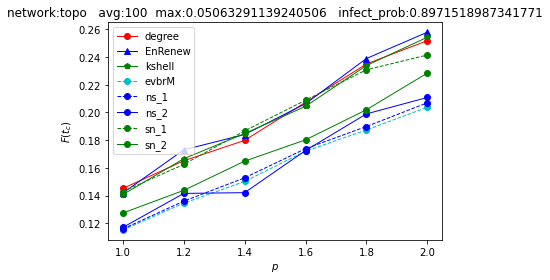

In [ ]:
%matplotlib inline
plt.title('network:{}   avg:{}  max:{}   infect_prob:{}'.format(data_file, avg, max_, infect_prob))
plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_result, 'r-o', label='degree', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_non_result, 'r--o', label='degree_non', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, vote_result, 'y-s', label='vote', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, vote_non_result, 'y--s', label='vote_non', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, newmethod_result, 'b-^', label='EnRenew', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, kshell_result, 'g-p', label='kshell', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, kshell_non_result, 'g--p', label='kshell_non', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, evbrM_result, 'c--o', label='evbrM', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, node_strength_rank_1_result, 'b--o', label='ns_1', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, node_strength_rank_2_result, 'b-o', label='ns_2', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, node_step_nbr_1_result, 'g--o', label='sn_1', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, node_step_nbr_2_result, 'g-o', label='sn_2', linewidth=1.0, )
plt.legend(loc="upper left")
plt.ylabel("$F(t_c)$")
plt.xlabel('$p$')
plt.show()


In [ ]:
node_cluster = cluster_optimal_nodes(G, opti_rank)
node_cluster

[('6', set()), ('3', {'0', '1'}), ('5', {'2', '4'})]

In [13]:
cover_prob = [infect_prob / a/10 for a in range(10, 21, 2)]
node_count = nx.number_of_nodes(G)


In [15]:
closeness_centrality_result = [(get_sir_result( G, closeness_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
degree_centrality_result = [(get_sir_result( G, degree_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
eigenvector_centrality_result = [(get_sir_result( G, eigenvector_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
load_centrality_result = [(get_sir_result( G, load_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
betweenness_centrality_result = [(get_sir_result( G, betweenness_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
current_flow_betweenness_centrality_result = [(get_sir_result( G, current_flow_betweenness_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
approximate_current_flow_betweenness_centrality_result = [(get_sir_result( G, approximate_current_flow_betweenness_centrality, topk, avg, infect_prob, a, max_iter)[-1] / node_count) for a in tqdm(cover_prob)]
# betweenness

100%|██████████| 6/6 [00:42<00:00,  7.10s/it]


 50%|█████     | 3/6 [11:55<11:55, 238.41s/it]


TypeError: unhashable type: 'numpy.ndarray'

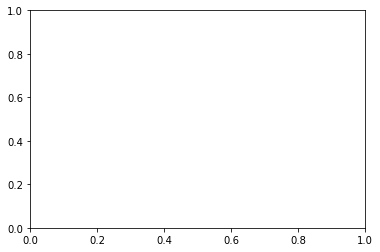

In [17]:
%matplotlib inline
# plt.title('network:{}   avg:{}  max:{}   infect_prob:{}'.format(data_file, avg, max_, infect_prob))
# plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_result, 'r-o', label='degree', linewidth=1.0, )
# # plt.plot(np.array(range(10, 21, 2)) / 10, degreerank_non_result, 'r--o', label='degree_non', linewidth=1.0, )
# # plt.plot(np.array(range(10, 21, 2)) / 10, vote_result, 'y-s', label='vote', linewidth=1.0, )
# # plt.plot(np.array(range(10, 21, 2)) / 10, vote_non_result, 'y--s', label='vote_non', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, newmethod_result, 'b-^', label='EnRenew', linewidth=1.0, )
# plt.plot(np.array(range(10, 21, 2)) / 10, kshell_result, 'g-p', label='kshell', linewidth=1.0, )
# # plt.plot(np.array(range(10, 21, 2)) / 10, kshell_non_result, 'g--p', label='kshell_non', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, opti_rank, 'c--o', label='evbrM', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, closeness_centrality_result, 'b--o', label='ns_1', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, degree_centrality_result, 'b-o', label='ns_2', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, eigenvector_centrality_result, 'g--o', label='sn_1', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, load_centrality_result, 'g-o', label='sn_2', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, betweenness_centrality_result, 'b-^', label='EnRenew', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, current_flow_betweenness_centrality_result, 'g-p', label='kshell', linewidth=1.0, )
plt.plot(np.array(range(10, 21, 2)) / 10, approximate_current_flow_betweenness_centrality_result, 'r-o', label='degree', linewidth=1.0, )
plt.legend(loc="upper left")
plt.ylabel("$F(t_c)$")
plt.xlabel('$p$')
plt.show()
